#### Large Language Models are stateless 
Each time it's prompted to generate a context, it has no recollection of prior context, in order to provide historical information, we need to keep track of previous conversation and context.

### Building a chatbot memory system

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [2]:
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant. Answer all questions to the best
         of your ability."""),
     ("placeholder", "{messages}"),
])

model = ChatOpenAI()

In [3]:
chain = prompt | model

chain.invoke({
    "messages": [
        ("human","""Translate this sentence from English to French: I love
             programming."""),
        ("ai", "J'adore programmer."),
        ("human", "What did you just say?"),
    ],
})

AIMessage(content='I said, "J\'adore programmer," which means "I love programming" in French.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 63, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn31uw6HW0joAGO6TA9Cya0TrA6tO', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--01657b85-ba6a-47c4-b16b-41ab8d78ca58-0', usage_metadata={'input_tokens': 63, 'output_tokens': 20, 'total_tokens': 83, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### LangGraph

LangGraph was developed to implement multiactor, multistep, stateful cognitive architectures, called graphs. There can be multiple actors for example, an LLM prompt asking a search tool for the results of a given search query. We need to make sense of the back-and-forth between multiple actors. Communication across steps requires tracking some state.

Each graph is made up of following components:

State:
The data received from outside the application, modified and produced by the application while it’s running.

Nodes:
Each step to be taken. Nodes are simply Python/JS functions, which receive the current state as input and can return an update to that state.

Edges:
The connections between nodes. Edges determine the path taken from the first node to the last, and they can be fixed (that is, after Node B, always visit node D)
or conditional.

#### Let's create a simple chatbot using LangGraph

In [4]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages`
    # function in the annotation defines how this state should
    # be updated (in this case, it appends new messages to the
    # list, rather than replacing the previous messages)
    messages: Annotated[list, add_messages]

builder = StateGraph(State)

Each node will receive the current state as well as a list of messages and it'll append it's own message to that list.

In [6]:
from langchain_openai import ChatOpenAI

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

builder.add_node("chatbot", chatbot)

In [7]:
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

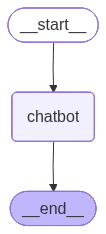

In [8]:
graph

In [9]:
from langchain_core.messages import HumanMessage, AIMessage

input = {"messages": [HumanMessage('hi')]}

In [10]:
input

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]}

In [11]:
list(graph.stream(input))

[{'chatbot': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn31w1Hmq6lVwtYy2jVlegoVnk5K8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--090d00fd-9f04-4d68-b54b-2cbb3f497dc7-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}]

In [12]:
for chunk in graph.stream(input):
    print(chunk['chatbot']['messages'][0].content)

Hello! How can I help you today?


In [14]:
input = {"messages": [HumanMessage("Tell me how to make chai")]}

list(graph.stream(input))

[{'chatbot': {'messages': [AIMessage(content="To make chai, you will need the following ingredients:\n\n- Water\n- Milk\n- Black tea leaves\n- Sugar\n- Spices (such as cinnamon, cardamom, ginger, cloves, and black pepper)\n\nHere's a basic recipe for making chai:\n\n1. In a saucepan, add water and bring it to a boil.\n2. Once the water is boiling, add the black tea leaves and spices to the saucepan. You can adjust the amount of spices based on your preference.\n3. Let the tea steep for a few minutes to allow the flavors to infuse.\n4. Add milk to the saucepan and bring the mixture to a simmer.\n5. Stir in sugar to taste. You can also use a sweetener of your choice.\n6. Strain the chai mixture into cups and serve hot.\n\nYou can customize your chai by adding other spices or ingredients like vanilla, nutmeg, or honey. Enjoy your homemade chai!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 193, 'prompt_tokens': 13, 'total_tokens': 206, 'com

In [15]:
for chunk in graph.stream(input):
    print(chunk['chatbot']['messages'][0].content)

Chai is a traditional Indian beverage made with black tea, milk, and a mix of spices. Here's a simple recipe to make chai at home:

Ingredients:
- 1 cup water
- 1 cup milk
- 1-2 teaspoons loose black tea leaves
- 2-3 whole cardamom pods
- 1-inch piece of fresh ginger, sliced
- 2-3 whole cloves
- 1 cinnamon stick
- Sugar (to taste)

Instructions:
1. In a saucepan, bring water to a boil.
2. Add the cardamom pods, ginger, cloves, and cinnamon stick to the boiling water.
3. Let the spices simmer in the water for 5-7 minutes to infuse their flavors.
4. Add black tea leaves and simmer for another 2-3 minutes.
5. Add milk and sugar to the saucepan and bring the mixture to a boil.
6. Let the chai simmer for a few minutes, stirring occasionally.
7. Strain the chai into cups and serve hot.

Feel free to adjust the recipe to suit your taste preferences by adding more or less of the spices or adjusting the amount of sugar. Enjoy your homemade chai!


Still contains one item in the list

In [13]:
# del builder.nodes["chatbot"]

# builder.add_node('chatbot', chatbot)
# builder.compile()

### Adding memory to StateGraph

We'll attach a checkpointer which is a storage adapter for LangGraph, here we'll use in-memory adapter which is appropirate for learning and prototyping, SQLite adapter can be used for local app testing and Postgres adapter for production applications.

In [16]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

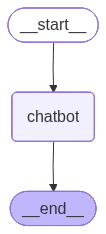

In [17]:
graph

Now it stores the state at the end of each step, so every invocation after the first doesn’t start from a blank slate. Any time the graph is called, it starts by using the checkpointer to fetch the most recent saved state, if any, and combines the new input with the previous state. And only then does it execute the first nodes.

In [18]:
thread_1 = {"configurable": {"thread_id": "1"}}

result1 = graph.invoke(
    {"messages": HumanMessage("Hi, my name is Hemant!")}
)

In [19]:
result1

{'messages': [HumanMessage(content='Hi, my name is Hemant!', additional_kwargs={}, response_metadata={}, id='242c3aee-10b6-47cd-97d4-320e44de14b9'),
  AIMessage(content='Hello Hemant! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 15, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn39jcYr1MuN5VsDq0cwt2Qfewgoh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--2a6b7184-2c23-433c-bc68-a6ef031ee319-0', usage_metadata={'input_tokens': 15, 'output_tokens': 11, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning':

In [21]:
result1['messages'][1].content

'Hello Hemant! How can I help you today?'

In [23]:
result2 = graph.invoke(
    {"messages": [HumanMessage("What is my name?")]},
    thread_1
)

In [32]:
result2

{'messages': [HumanMessage(content='Hi, my name is Hemant!', additional_kwargs={}, response_metadata={}, id='242c3aee-10b6-47cd-97d4-320e44de14b9'),
  AIMessage(content='Hello Hemant! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 15, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn39jcYr1MuN5VsDq0cwt2Qfewgoh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--2a6b7184-2c23-433c-bc68-a6ef031ee319-0', usage_metadata={'input_tokens': 15, 'output_tokens': 11, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning':

In [31]:
len(result2['messages'])

4

In [33]:
result2['messages'][3].content

'Your name is Hemant!'

In [34]:
graph.get_state(thread_1)

StateSnapshot(values={'messages': [HumanMessage(content='Hi, my name is Hemant!', additional_kwargs={}, response_metadata={}, id='242c3aee-10b6-47cd-97d4-320e44de14b9'), AIMessage(content='Hello Hemant! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 15, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn39jcYr1MuN5VsDq0cwt2Qfewgoh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--2a6b7184-2c23-433c-bc68-a6ef031ee319-0', usage_metadata={'input_tokens': 15, 'output_tokens': 11, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audi

In [36]:
# invoked with different thread, doesn't know my name

thread_2 = {"configurable": {"thread_id": "2"}}
graph.invoke({"messages": HumanMessage("Who am I?")}, thread_2)

{'messages': [HumanMessage(content='Who am I?', additional_kwargs={}, response_metadata={}, id='e1869230-e318-4aef-949b-52bedb35575e'),
  AIMessage(content='I am a language model AI developed by OpenAI. What can I help you with today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 11, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn3LH50rFnMr8wMZsxgCS1AxyOD0e', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--53645c2d-afdf-48a5-a03e-e68ce56b6032-0', usage_metadata={'input_tokens': 11, 'output_tokens': 19, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': 

In [43]:
list(graph.get_state_history(thread_1))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi, my name is Hemant!', additional_kwargs={}, response_metadata={}, id='242c3aee-10b6-47cd-97d4-320e44de14b9'), AIMessage(content='Hello Hemant! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 15, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn39jcYr1MuN5VsDq0cwt2Qfewgoh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--2a6b7184-2c23-433c-bc68-a6ef031ee319-0', usage_metadata={'input_tokens': 15, 'output_tokens': 11, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'aud

### Modifying chat history

In many cases chat history is not in the best format to generate an accurate response, so we would need to modify it, there are 3 main ways of doing this:
trimming, filtering, and merging messages

#### Trimming messages:

As the messages keep growing it might exceed the allowed context_window, so we need to have a strategy to limit the number of messages retrieved from chat history and append to the prompt.

In [46]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy='last',
    token_counter=ChatOpenAI(model='gpt-4o'),
    include_system=True,
    allow_partial=False,
    start_on='human',
)

In [48]:
# let's see it in action by passing a bunch of messages

messages = [
    SystemMessage(content="You are a helpful assistant."),
    HumanMessage(content='Hi, my name is Hemant!'),
    AIMessage(content='Hi Hemant, how can I help you today.'),
    HumanMessage(content='I like anstronomy stuff.'),
    AIMessage(content='Nice.'),
    HumanMessage(content='What is 2 + 2'),
    AIMessage(content='4'),
    HumanMessage(content='Thanks!'),
    AIMessage(content="You're welcome!"),
    HumanMessage(content='What is the captial of France?'),
    AIMessage(content='Paris')
]

trimmer.invoke(messages)

[SystemMessage(content='You are a helpful assistant.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='What is 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Thanks!', additional_kwargs={}, response_metadata={}),
 AIMessage(content="You're welcome!", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='What is the captial of France?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Paris', additional_kwargs={}, response_metadata={})]

#### Filter messages

As the list of chat history messages grows, a wider variety of types, subchains, and models may be utilized. LangChain’s filter_messages helper makes it easier to filter the chat history messages by type, ID, or name.

In [50]:
from langchain_core.messages import filter_messages

messages = [
 SystemMessage("you are a good assistant", id="1"),
 HumanMessage("example input", id="2", name="example_user"),
 AIMessage("example output", id="3", name="example_assistant"),
 HumanMessage("real input", id="4", name="bob"),
 AIMessage("real output", id="5", name="alice"),
]

filter_messages(messages, include_types='human')

[HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4')]

In [52]:
filter_messages(messages, include_ids=["1","2","5"])

[SystemMessage(content='you are a good assistant', additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 AIMessage(content='real output', additional_kwargs={}, response_metadata={}, name='alice', id='5')]

In [53]:
filter_messages(messages=messages, include_names=["example_user", "bob"])

[HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4')]

In [55]:
filter_messages(messages, include_types=[HumanMessage,AIMessage], exclude_ids=["3"])

[HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4'),
 AIMessage(content='real output', additional_kwargs={}, response_metadata={}, name='alice', id='5')]

#### Merging consecutive messages

Certain models like Anthopic's chat model doesn't support consecutive messages of same type, so we can merge them.

In [58]:
from langchain_core.messages import merge_message_runs

messages = [
    SystemMessage("you're a good assistant."),
    SystemMessage("you always respond with a joke."),
    HumanMessage(
        [{"type": "text", "text": "i wonder why it's called langchain"}]
    ),
    HumanMessage("and who is harrison chasing anyway"),
    AIMessage(
        '''Well, I guess they thought "WordRope" and "SentenceString" just
        didn't have the same ring to it!'''
    ),
    AIMessage("""Why, he's probably chasing after the last cup of coffee in the
        office!"""),
]

message_new = merge_message_runs(messages)

In [61]:
message_new[1].content

[{'type': 'text', 'text': "i wonder why it's called langchain"},
 'and who is harrison chasing anyway']

In [63]:
message_new[1].content[0]['text']

"i wonder why it's called langchain"